In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import pylab as pl
import astropy.units as u
import astropy.table as tb
from astropy.table import QTable
path = os.getcwd().split('/')
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/Mestrado/cenarios/mandyoc/scripts_gera_inputs_imgs/new_outputs/des.mplstyle')

In [2]:
def read_params(fpath):
    '''
    Read Nx, Nz, Lx, Lz from param.txt
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz


def read_data(prop, step, fpath):
    '''
    Read and process data according to parameters
    '''
    Nx, Nz, Lx, Lz = read_params(fpath)
    file_name = prop+"_"+str(step)+".txt"

    A = np.loadtxt(fpath+file_name, unpack=True, comments="P", skiprows=2)
    TT = A*1.0
    TT[np.abs(TT)<1.0E-200]=0
    TT = np.reshape(TT, (Nx,Nz), order='F')
    TTT = TT[:,:]

    return TTT
        
def read_density(fpath, step, Nx, Nz):
    '''
    Read density data from density_step.txt to extract interfaces
    '''

    Rho = np.loadtxt(fpath+"density_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Rho = np.reshape(Rho, (Nz, Nx))

    return Rho

def extract_interface(z, Z, Nx, Rhoi, rho):
    '''
    Extract interface according to a given density
    '''

    topo_aux = []

    for j in np.arange(Nx):
        topoi = interp1d(z, Rhoi[:,j]) #return a "function" of interpolation to apply in other array
        idx = (np.abs(topoi(Z)-rho)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)

    return topo_aux

def find_nearest(array, value):
    '''Find the index in _array_ nearest to a given _value_'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_times_steps(fpath):
    steps = []
    times = []
    
    ts = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    total_curves = len(ts)
    step_initial = int(ts[0].split('/')[-1][5:-4])
    step_final = int(ts[-1].split('/')[-1][5:-4])
    dstep = int(ts[1].split('/')[-1][5:-4]) - int(ts[0].split('/')[-1][5:-4])

    for step in range(step_initial, step_final+1, dstep):
        step = int(step)
        time_fname = "time_" + str(step) + ".txt"
        time = np.loadtxt(fpath+time_fname, usecols=2, max_rows=1)
        time = round(time/1.0E6, 2)
        steps = np.append(steps, int(step))
        times = np.append(times, time)

    steps = steps.astype('int')
    return times, steps

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_topography(fpath, ax, axs, instant, step, letter, xlims, ylims):

    Nx, Nz, Lx, Lz = read_params(fpath)

    ##Creating a grid to plot
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)
    
    z_mean = 40.0 #np.mean(topo[condx])
    
    fname = fpath+'sp_surface_global_' + str(step) + '.txt'
    topo = np.loadtxt(fname, unpack=True, skiprows=2, comments='P')/1.0E3
    topo = topo + 40
    condx = (xi >= 100) & (xi <= 400)
    mean = np.mean(topo[condx])
    topoi = topo - np.abs(mean)
    
    Rhoi = read_density(fpath, step, Nx, Nz)
    interfaces=[2900, 3365]
    ##Extract layer topography
    z = np.linspace(Lz/1000.0, 0, Nz)
    Z = np.linspace(Lz/1000.0, 0, 8001) #zi
    x = np.linspace(Lx/1000.0, 0, Nx)

    topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
    topo_interface -= np.abs(z_mean) #h_air
    condx = (xi >= 0) & (xi <= 100)
    mean = np.mean(topo_interface[condx])
    topo_interface = topo_interface + np.abs(mean)
    topo_interface = -1.0*topo_interface
    
    ax.plot(xx[0], topo_interface, '-', color='xkcd:purple')
#     ax.plot(xx[0], topo, '-', color='xkcd:black')
#     ax.plot(xx[0], topoi, '-', color='xkcd:blue')

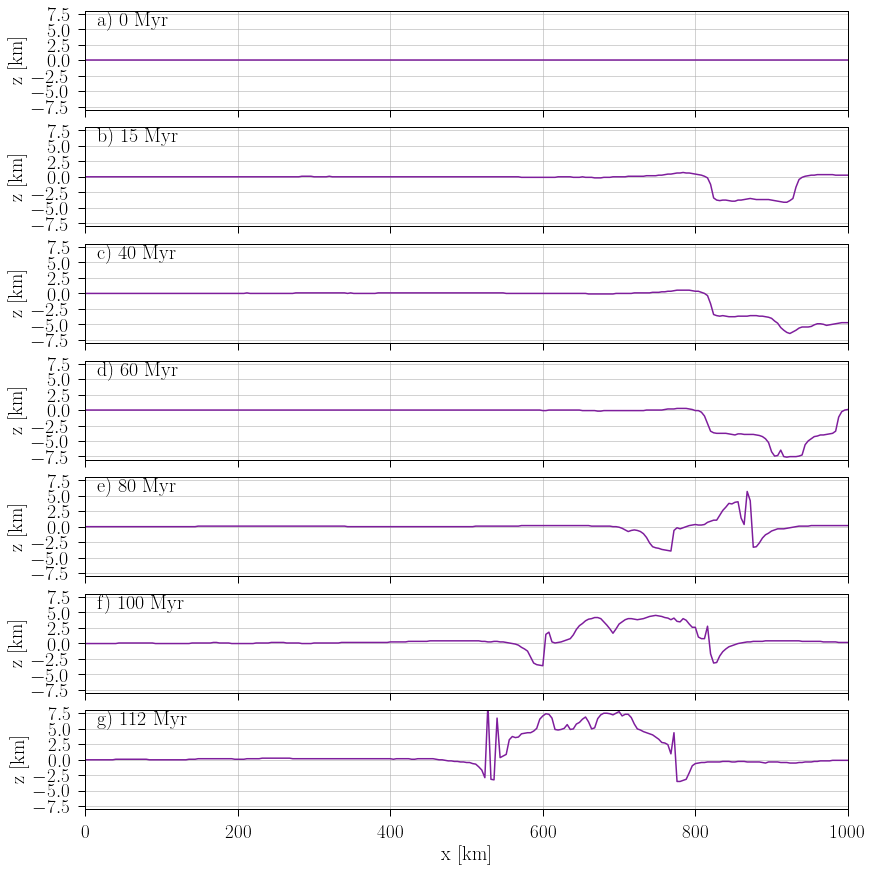

In [3]:
# scenario = 'Sim001_rheol19_acc_PT200/'
# fpath = machine_path+'/Doutorado/cenarios/mandyoc/accordion/' + scenario

scenario = 'Sim002_rheol19_acc_PT200/'
fpath = machine_path+'/Doutorado/cenarios/mandyoc/accordion/' + scenario

# instants = [0, 10, 25, 40] #Myr
# instants = [0, 15, 40, 60, 80, 100, 120] #Myr
instants = [0, 15, 40, 60, 80, 100, 112] #Myr
times, steps = read_times_steps(fpath)
xlims = [0, 1400]
ylims = [-150, 40]

fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,12), sharex=True, sharey=True)
axs = trim_axs(axs, len(instants))
prop = 'strain'
# prop = 'strain_rate'
alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

for instant, ax, letter in zip(instants, axs, letters):
    idx = find_nearest(times, instant)
    step = steps[idx]
    
    plot_topography(fpath, ax, axs, instant, step, letter, xlims, ylims)
    
###################################################################################################
xlims = [0, 1000]
ylims = [-8, 8]

axs[0].set_xlim(xlims)
axs[0].set_ylim(ylims)

fsize = 20
axs[-1].set_xlabel('x [km]', fontsize=fsize)
for ax, letter, instant in zip(axs, letters, instants):
    ax.grid('-k', alpha=0.7)
    ax.text(0.015, 0.90, letter+') '+str(instant)+' Myr',
        color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, zorder=52)
    
    ax.set_ylabel('z [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    axs[-1].tick_params(axis='both', labelsize=fsize-1)
    ax.set_yticks(np.linspace(ylims[0]+0.5, ylims[1]-0.5, 7))
    
    
prop='topography'    
figname = scenario[:-1] + '_'+prop
fig.savefig('out/plots/' + figname+'.pdf', dpi=400)
fig.savefig('out/plots/' + figname+'.png', dpi=400)